# Generative Adversarial Networks
In this section we introduce an unsupervised learning problem, argue why this problem seems completely unreasonable to solve, and then show how Generative Adversarial Networks (GANs) provide an ingenious approach to solving the problem. By the end of the notebook you will be able to use GANs to generate do the following: 

<img src="gifs/n(0,1) to n(4,2)/gif.gif">


<b>Problem</b>: Suppose you have samples $x_1,...,x_n\sim p_d$ and you want to sample from $p_d$, that is, produce new samples $x\sim p_d$. 

Let us first consider a simple special case of this problem: 
<br><br>

<div style="width: 80%; border: 1px solid black; padding: 12px; margin-left: 10%; background-color: #efefef;">
    <b>Example 1:</b> <br>
    The above general problem seems very hard. But suppose we actually knew that $p_d=N(\mu, \sigma^2)$. We could then estimate the sample mean $\hat{\mu}$ and sample standard deviation $\hat{\sigma}$:
    <br><br>
    <div style="text-align: center; width:100%;">$\hat{\mu}=\frac{1}{n} \sum_{i=1}^N x_i\quad\quad\quad \hat{\sigma}=\sqrt{\frac{\sum_{i=1}^N (x_i-\hat{\mu})^2}{N-1}}$</div>
    <br>
    We can then sample from  $x\sim N(\hat{\mu}, \hat{\sigma}^2)$. This approach can actually be shown to yield the <a href="https://en.wikipedia.org/wiki/Maximum_likelihood_estimation">MLE</a>. 
</div>

Unfortunately, the data we are typically interested in does <b>not</b> follow a nice distribution in any way. Imagine a distribution of dog images, human speech or natural language. These distributions are remarkably complicated, assuming that they follow a nice distribution like the normal distribution is completely unreasonable. 

That said, we might be able to approxmiate the data distribution $p_d$ by transforming a normal distribution using a very complicated function $g$. In other words, consider the implicit distribution $p_g$ that arrises by transforming $z\sim N(0, 1)$ using a function $g$ so $g(z)=p_g$. If we find a $g$ such that $p_g$ approximates $p_d$ we could sample $z\sim N(0,1)$ and then compute $g(z)$. 

To formalize "$p_g$ <i>approximates</i> $p_d$" we define an error function between $p_g$ and $p_d$ and attempt to solve the optimization problem that arises: 

$$g^*=\text{arg }\text{min}_{g\in G} \text{ error}(p_g, p_d)\quad\quad\text{for hypothesis set } G$$

This is similar to how we usually approach supervised machine learning. In supervised learning, we want to approximate some unkown target function $f:\mathcal{X}\rightarrow \mathcal{Y}$. This is done by solving the optimization problem that arises by defining an error function which can then be minimized. This is the exact same approach we applied above. 

There exists a group of functions called <i>divergences</i> which provide a measure on how different one distribution is from another. One example is the Kullback-Leibler divergence (KL divergence for short):

$$D_{KL}(p_g, p_d) = \sum_x p_d(x) \log \left( \frac{ p_d(x) } { p_g(x)} \right) $$

By using the KL divergence as error function we can formulate our problem as: 

$$
\begin{align}
g^*&=\text{arg }\text{min}_{g\in G} \; D_{KL}(p_g, p_d)\\
&=\text{arg }\text{min}_{g\in G} \sum_x p_d(x) \log \left( \frac{ p_d(x) } { p_g(x)} \right)\quad\quad(1)
\end{align}
$$

Unfortunately, attempting to solve this problem seems completely out of reach, even computing $D_{KL}$ is troublesome:
1. There is no obvious way for us to compute $p_d(x)$ or $p_g(x)$. Furthermore, our goal is to generate samples from $p_d(x)$, if we knew a way to efficiently compute $p_d(x)$ the problem is essentially solved. 
2. The sum over $x$ is a sum over all images. Even if we have small $32$ times $32$ grayscale images where each pixel is one byte, there would be $255^{32^2}$ images.

It turns out that different GAN variants can be shown to minimize different variants of (1) without explicitly compute any divergences. This was shown in a followup article [1] we cover in Week 2. In the following section we introduce GANs and provide some insight into the theoretical results of the first article. 




## Training Generative Adversarial Networks
Our goal is to find a function $g$ that implicitly defines a probability distribution $p_g$ by transforming $p_z=N(0,1)$ into fakes $g(z)=p_g$, such that fake samples $f_i\sim p_g$ are indistinguishable from real samples $x_i\sim p_d$. Instead of using a divergence to measure error between $p_g$ and $p_d$, we introduce a function $d$ which attempts to distinguish between real and fake sampels. We usually call $g$ the generator and $d$ the discriminator. See the illustration below: 

<br><div class="figure" style="width: 100%; text-align: center; ">
<img src="figs/week1_gan.png" style="width: 80%;" ><br>
    <b>Figure 1: </b>A schematic of a Generative Adversarial Network.  
</div>

The discriminator recieves both real images $x_1,...,x_n\sim p_d$ and fake images from the generator $g(z_1),...,g(z_n)\sim p_g$. The objective of the discriminator is to predict $1$ on real images $x$ and $0$ on fake images $g(z)$. On the other hand, the objective of the generator is to fool the discriminator into predicting $1$ on a fake image $g(z)$. The objectives of the generator and discriminator are thus conflicting, the generator wins if the discriminator losses (see <a href="https://en.wikipedia.org/wiki/Zero-sum_game">zero-sum games</a>). 

The game is captured by the following equation:

$$\text{min }_g\text{ max}_d\; \mathbb{E}_{x\sim p_d}[\text{log d(x)}] + \mathbb{E}_{z \sim p_z}[1-\text{log(d(g(z))}] \quad\quad(2)$$

<b>Discriminator: </b><br>
Consider (2) without the $\text{min}_g$ by fixing some $g$. The first term with $d(x)$ for $x\sim p_d$ corresponds to maximizing the discriminators probability estimate of real data being real. The second term $1-d(g(z))$ for $z\sim p_z$ (which is maximized by $d(g(z))=0$) corresponds to maximizing its probability estimate of fake data being fake. In practice we approximate the expectations by using a training sample $D_{disc}$ for which we minimize cross entropy: 

$$ D_{disc}=\{(x_1, 1), \cdots , (x_n, 1), (g(z_1), 0), \cdots , (g(z_n), 0) \}$$

$$\text{max}_d \sum_{(x,y)\in D_{disc}} y\text{ log }d(x) + (1-y)\text{ log }(1-d(x)) $$

Notice that the problem from the perspective of the discriminator is completely supervised, even though the labels are artificial in the sense they were not made by humans, but are a product of the way the discrimiantor and generator relate to each other. 

<b>Generator: </b><br>
The first term of (2) does not depend on the generator. The second term $1-d(g(z))$ for $z\sim p_z$ corresponds to minimizing the discriminators probability estimate of fake data being fake, in other words, fool the discriminator. Again, in practice we approximate the expectation by using a training sample $D_{gen}$: 

$$ D_{gen}=\{ (x_1, 1), ..., (x_n, 1), (z_1, 0), ..., (z_n, 0) \} $$

$$\text{min}_g \sum_{(x,y)\in D_{gen}} y\text{ log }d(x) + (1-y)\text{ log }(1-d(g(x))) $$

Since we are minimizing with respect to $g$ we can equivalently minimize the equation below without the first term: 

$$\text{min}_g \sum_{(x,y)\in D_{gen}} (1-y)\text{ log }(1-d(g(x))) $$

$$ D_{gen}=\{ (z_1, 0), ..., (z_n, 0) \} $$


There are two important observations to be made: (1) from the perspective of the generator the problem is supervised and (2) the discriminator $d$ plays a vital role in the error function of the generator $g$, one can think of the discriminator as a replacement for using divergences as error functions.   

<b>Both smaller problems are supervised!</b><br>
The original article [2] proved (relative to a few assumptions) that the generator $g$ eventually recovers the true data distribution so $p_g=p_d$. The following section clarifies the assumptions needed. 

It was later proved in [1] that iteratively training $g$ and $d$ as proposed in GANs approximately minimizes a variant of (2). Furthermore, they showed an intruiging relationship between different GAN formulations of (2) can be shown to minimize different divergences. 

One way to think of their result, is that the GAN framework allow us to approximately minimize the original unsupervised learning problem of (1) by splitting the problem into to supervised subproblems. This is quite remarkable, remember that the simply evaluating the divergence used in (1) is infeasible!

# Convergence Guarantees from [2]
In this section we present a high level walkthrough of the ideas and assumptions used in [2] to prove convergence of GAN tranining as presented above. Full proofs can be found in [2] pages 4-5. 


>
><b>Proposition 1.</b> For $g$ fixed, the optimal discriminator $d$ is
>$$d^*_g(x)=\frac{p_{data}(x)}{p_{data}{x}+p_g(x)}$$
>

<b>High Level Idea: </b><br>
Think of the (2) from the perspective of the generator $g$. No matter how the generator attempts to minimize the loss, the discriminator will attempt to counter its move and maximize the loss. Could the generator somehow predict the actions of the discriminator, and then take these actions into consideration when minimizing (2)?  

One idea from game-theory is to assume your opponent always manages to find its own optimal strategy. This makes it easier to predict the actions of your opponent. From the perspective of $g$, this corresponds to adapting the worst-case scenario perspective where the discriminator $d$ always counters whatever $g$ does in the best possible way.    

In this context the proposition gives us an explicit formula for the optimal $d^*_g$ given a fixed $g$. 

<b>Sketch of Proof: </b><br>Recall that equation (2) states the following:

$$\begin{align}
&\text{min }_g\text{ max}_d\; \mathbb{E}_{x\sim p_d}[\text{log d(x)}] + \mathbb{E}_{z \sim p_z}[1-\text{log(d(g(z))}]
\end{align}$$

Since $p_g$ is defined to be the distribution that arrises when applying $g$ on $z\sim p_z$ we can write this as: 

$$
\text{min }_g\text{ max}_d\; \mathbb{E}_{x\sim p_d}[\text{log d(x)}] + \mathbb{E}_{x \sim p_g}[1-\text{log(d(x))}]
$$

Using the definition of expectation we can rewrite this to:  

$$\begin{align}
&\int_x p_{d}(x)\text{ log }(d(x))\;dx+\int_x p_g(x)\text{ log }(1-d(x)) \;dx\\
= &\int_x p_{d}(x)\text{ log }(d(x))+p_g(x)\text{ log }(1-d(x)) \;dx
\end{align}$$

The goal is to figure out which $d(x)$ optimally maximize the above equation. The equation can be rewritten to $a\log(d(x))+b \log(1-d(x))$ which for $(a,b)\in \mathbb{R}\backslash \{0, 0\}$ is maximized in $[0,1]$ when $d(x)=a/(a+b)$. It thus follows that the optimal $d^*_g(x)$ for some $g$ is given: 

$$d^*_g(x)=\frac{p_d(x)}{p_d(x)+p_g(x)}$$


>
> <b>Theorem 1.</b> The global minimum of the virtual training criterion $C(g)$ is achieved if and only if
> $p_g=p_d$ . At that point, $C(g)$ achieves the value $-\log(4)$. 
>
>$$C(g)= \text{max }_d \; \mathbb{E}_{x\sim p_d}[\text{log d(x)}] + \mathbb{E}_{z \sim p_z}[1-\text{log(d(g(z))}]$$
>

<b>High Level Idea: </b><br>
In Proposition 1 we found the optimal discriminator for any generator. We now try to figure out what the optimal thing for the generator is assuming it has to play against an optimal discriminator. It turns out that the best value for $g$ occurs when it recovers the data distribution so $p_g=p_d$. 

<b>Sketch of Proof: </b><br>
If $p_g=p_d$ proposition 1 tells us that the best discriminator is $d^*_g(x)=1/2$. This essentially just says if the discriminator has to discriminate between <i>real data</i> and <i>fake data</i> the best thing it can do is flip a coin. In this case we get that $C(g)=\log(1/2)+\log(1/2)=-\log(4)$. It turns out the function $C(g)$ has a unique optimum that happens exactly at $-\log(4)$, this then implies that the global optimum happens if and only if $p_g=p_d$. Below we show that $C(g)$ has a unique optimum that happens exactly at $-\log(4)$. 

Using Proposition 1 we can rewrite $C(G)$ as follows: 

$$
\begin{align}
C(g)&=\text{max }_d \; \mathbb{E}_{x\sim p_d}[\text{log d(x)}] + \mathbb{E}_{z \sim p_z}[1-\text{log(d(g(z))}]\\
&=\; \mathbb{E}_{x\sim p_d}[\log( d^*_g(x) ] + \mathbb{E}_{z \sim p_z}[1-\log(d^*_g(g(z)))] \\
&=\; \mathbb{E}_{x\sim p_d}[\log( d^*_g(x) ] + \mathbb{E}_{x \sim p_g}[1-\log(d^*_g(x))]
\end{align}
$$

If we now use Proposition 1 we get the following: 

$$
\begin{align}
\mathbb{E}_{x\sim p_d}[\log( \frac{p_d(x)}{p_d(x)+p_g(x)} ) ] + \mathbb{E}_{x \sim p_g}[1-\log(\frac{p_d(x)}{p_d(x)+p_g(x)})]
\end{align}
$$

By using log rules we get that: 

$$
\begin{align}
\mathbb{E}_{x\sim p_d}[\log( \frac{p_d(x)}{p_d(x)+p_g(x)}) ] + \mathbb{E}_{x \sim p_g}[\log(\frac{p_g(x)}{p_d(x)+p_g(x)})]
\end{align}
$$

This is exactly the $KL$ divergence :

$$
\begin{align}
D_{kl}(p_d \mid\mid p_d+p_g) + D_{kl}(p_g \mid\mid p_d+p_g)
\end{align}
$$

By adding and subtracting the above equation with $\log(2)+\log(2)$ we can rewrite it as in terms of the <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence">Jensen-Shanon</a> divergence. 

$$
\begin{align}
2 \cdot D_{JS}(p_d\mid\mid p_g)=D_{kl}(p_d \mid\mid \frac{p_d+p_g}{2}) + D_{kl}(p_g \mid\mid \frac{p_d+p_g}{2})
\end{align}
$$

It is thus possible to write $C(g)$ as 

$$
\begin{align}
C(g)&=-\log(4)  + 2\cdot D_{JS}(p_d\mid\mid p_g)
\end{align}
$$

Since the JS divergence is always positive, we get a lowerbound $-\log(4)\le C(g)$. Furthermore, the value $-\log(4)$ is zero only when its argument are equal, so the value $-\log(4)$ is a unique optimum for $C(g)$. 

> <b>Proposition 2.</b> If $g$ and $d$ have enough capacity, and at each step of Algorithm 1, the discriminator
>is allowed to reach its optimum given $g$, and $p_g$ is updated so as to improve the criterion
>
>$$\mathbb{E}_{x\sim p_{d}}[\text{log }d^*_g(x)]+\mathbb{E}_{x\sim p_g}[\text{log }(1-d^*_g(x))]$$
>
>then $p_g$ converges to $p_d$. 

<b>High Level Idea: </b><br>
The previous proposition and theorem stated properties of the GAN game. What we really care about is the GAN algorithm converging so $g$ approximately learns the distribution. This second proposition gives us a convergence guarantee under three assumptions: 
1. Both $g$ and $d$ have enough capacity
2. At each step $d$ reaches its optimum given $g$
3. $p_g$ is update to improve the criterion (in practice $g$ might start overfitting causing this to be false)

<b>Sketch of Proof: </b><br>
See [2] page 5. 

# Code

## Transforming $N(0, 1)$ to $N(4, 2)$.
In this section we use a gan to translate $N(0, 1)$ to $N(4, 2)$. If $z\sim N(0,1)$ and $g(x)=x\sqrt{2}+4$ then $g(z)\sim N(4,2)$. It thus suffices to choose the generator to be an affine transform $g(x)=ax+b$. This makes for a fairly simple neural network: <br><br>


<div style="text-align: center">
<img src="figs/week1_architecture.png" style="width: 80%;">
<b>Figure 2: </b>A schematic of the simple model for this example.  
</div>

The following animation show how during training: (1) the generated is updated to the fake data distribution $p_g$ approaches the real data distribution $p_d$ and (2) the discriminator decision boundary, think of this as how the discriminator punishes the generator for having a difference between the fake data distribution $p_g$ and the real data distribution $p_d$.  

<div style="text-align: center">
<img src="gifs/n(0,1) to n(4,2)/gif.gif">
<b>Figure 3: </b>Animation of how $p_g$ converges towards $p_d$.
</div>


<b>Abstract Idea of Code: </b><br>
The code is implemented using Keras. The code uses Keras to define a generator and discriminator neural network. For the generator we also define an optimizer so we can train it on real/fake images. The generator needs to use the discriminator as a cost function. We do this by freezing the discriminators weights $\text{discriminator.trainable = False}$ so we can define an optimizer for the generator without having it change the discriminator. 

All plots are made using matplotlib. 

Using TensorFlow backend.


<IPython.core.display.Javascript object>


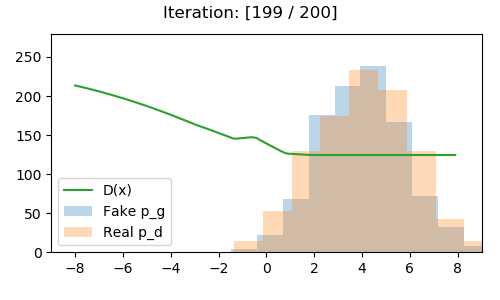

/home/fhv/anaconda3/envs/ml18/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [1]:
%matplotlib notebook 
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt # plot how normal distribution changes. 

"""
    Construct a very simple generator and a somehow larger discriminator. 
    Train the generator on N(0,1) with real data N(4,2) and plot each iteration. 
"""

fig, ax = plt.subplots(figsize=(5, 3))

def plot(): 
    ax.cla()
    ax.hist(generator.predict_on_batch(noise) , alpha=0.3, label="Fake p_g")
    ax.hist(real_data , alpha=0.3, label="Real p_d")
    xs = np.arange(-8, 8, 0.1)
    pred = discriminator.predict_on_batch(xs)
    ax.plot(xs, pred*250, label="D(x)")
    ax.legend(loc=3)
    ax.set_ylim([0, 280])
    ax.set_xlim([-9, 9])
    
    fig.suptitle("Iteration: [%i / %i]"%(i, iterations))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.canvas.draw()
    plt.savefig("gifs/n(0,1) to n(4,2)/%i.png"%i)
    plt.pause(.01)

# number of samples. 
n = 1000
iterations = 200
repeat = 10

# define generator
generator = Sequential()
generator.add(Dense(1, input_dim=1)) # one neuron except bias, don't have the relu activation!

# define discrimiantor
discriminator = Sequential()
discriminator.add(Dense(10, input_dim=1, activation="relu")) # non linearity has some use here. 
discriminator.add(Dense(1,  activation="sigmoid"))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Combine models
gan = Sequential()
gan.add(generator)
discriminator.trainable = False # from the gan model we freeze discriminator to use it as loss function
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Do several updates, plot some interval of iterations fake / real data. 

for i in range(iterations):
    
    noise     = np.random.normal(0, 1, size=(n, 1))
    fake_data = generator.predict(noise)
    real_data = np.random.normal(4, 2, size=(n, 1))
    
    disc_X = np.concatenate((real_data, fake_data), axis=0)
    disc_y = np.concatenate((np.zeros(n), np.ones(n)), axis=0) # flip labels since we min instead of max. 
    
    plot()
    for j in range(repeat): discriminator.train_on_batch(x=disc_X, y=disc_y)
    for j in range(repeat): gan.train_on_batch(x=noise, y=np.zeros(n))



<!-- 

## Transforming $U(0,1)^{64}$ to MNIST


TODO: find an architecture that works somewhere, and reference that. 

%matplotlib notebook 
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt # plot how normal distribution changes. 
from keras.layers.normalization import BatchNormalization

"""
    Same as above but on MNIST with arhictecture inspired by [github?/X] 
"""

fig, ax = plt.subplots(1, 4, figsize=(5, 2))

def plot(fake_data, current_iteration): 
    fig.suptitle("Iteration: [%i / %i]"%(current_iteration, iterations))

    for i in range(4): 
        ax[i].imshow(fake_data[0].reshape(28, 28), cmap="gray")
        ax[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.canvas.draw()
    plt.savefig("gifs/mnist/%i.png"%current_iteration)
    plt.pause(.01)

# number of samples. 
iterations = 2000
repeat = 10
mini_batch = 32
n = 60000


from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255 # normalize to [0,1]
x_train = x_train.reshape(60000, 28**2)

# define generator
generator = Sequential()
generator.add(Dense(128, input_dim=64, activation="relu")) 
generator.add(BatchNormalization())
generator.add(Dense(256, activation="relu"))  
generator.add(BatchNormalization())
generator.add(Dense(28**2, activation="sigmoid"))

# define discrimiantor
discriminator = Sequential()
discriminator.add(Dense(512, input_dim=28**2, activation="relu")) 
discriminator.add(BatchNormalization())
discriminator.add(Dense(256, activation="relu")) 
discriminator.add(BatchNormalization())
discriminator.add(Dense(1,  activation="sigmoid"))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Combine models
gan = Sequential()
gan.add(generator)
discriminator.trainable = False # from the gan model we freeze discriminator to use it as loss function
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Do several updates, plot some interval of iterations fake / real data. 

for i in range(iterations):
    
    print("\r[%i / %i]"%(i, iterations), end="")
    noise     = np.random.uniform(0, 1, size=(mini_batch, 64))
    fake_data = generator.predict_on_batch(noise)
    real_data = x_train[np.random.permutation(n)[:mini_batch]]
              
    disc_X = np.concatenate((real_data, fake_data), axis=0)
    disc_y = np.concatenate((np.zeros(mini_batch), np.ones(mini_batch)), axis=0) # flip labels since we min instead of max. 
    
    if i % 200 == 0: plot(fake_data, i)
    for j in range(repeat): discriminator.train_on_batch(x=disc_X, y=disc_y)
    for j in range(repeat): gan.train_on_batch(x=noise, y=np.zeros(mini_batch))




-->


# References
[[1]](http://papers.nips.cc/paper/6066-f-gan-training-generative-neural-samplers-using-variational-divergence-minimization.pdf) Nowozin, S., Cseke, B. and Tomioka, R., 2016. f-gan: Training generative neural samplers using variational divergence minimization. In Advances in Neural Information Processing Systems (pp. 271-279).

[[2]](https://papers.nips.cc/paper/5423-generative-adversarial-nets) Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A. and Bengio, Y., 2014. Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680).
